In [1]:
import os
import numpy as np
import torch
import pydicom
import matplotlib.pyplot as plt
from tcia_utils import nbia
from monai.bundle import ConfigParser, download
from monai.transforms import LoadImage, LoadImaged, Orientation, Orientationd, EnsureChannelFirst, EnsureChannelFirstd, Compose
from rt_utils import RTStructBuilder
from scipy.ndimage import label, measurements
import json

In [2]:
datadir = 'C:\\Users\\OskarK\\Desktop\\Segmentation\\Data'

# Part 1: Open CT Image

First we'll download the CT data we'll be using to the data directory

* This data was obtained from the cancer imaging archive

In [3]:
cart_name = "nbia-56561691129779503"
cart_data = nbia.getSharedCart(cart_name)
df = nbia.downloadSeries(cart_data, format="df", path = datadir)

2024-04-25 20:45:41,508:INFO:Calling... https://services.cancerimagingarchive.net/nbia-api/services/v1/getContentsByName with parameters {'name': 'nbia-56561691129779503'}
2024-04-25 20:45:42,190:INFO:Downloading 1 Series Instance UIDs (scans).
2024-04-25 20:45:42,851:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668 already downloaded.
2024-04-25 20:45:42,851:INFO:Downloaded 0 out of 1 Series Instance UIDs (scans).
0 failed to download.
1 previously downloaded.


In [4]:
CT_folder = os.path.join(datadir, '1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668')

## Option 1: Using `pydicom`

In [5]:
ds = pydicom.read_file(os.path.join(CT_folder, '1-394.dcm'))

We can obtain pixel data by accessing the `pixel_array` attribute

In [6]:
image = ds.pixel_array
image.shape

(512, 512)

Note that the image is a 2D array. Typically the pixel values are stored in a scaled format so we should adjust them:

In [7]:
image = ds.RescaleSlope * image + ds.RescaleIntercept

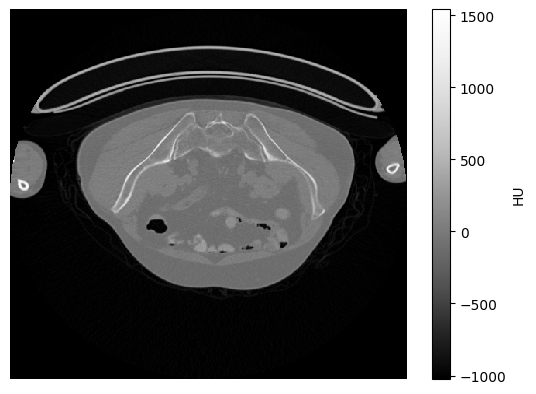

In [8]:
plt.pcolormesh(image, cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

## Option 2: Using `monai`

MONAI stands for "Medical Open Network for Artificial Intelligence" and is essentially an extension of PyTorch for machine learning with medical data, containing **many many many** important functions. If you're doing AI research in medicine, you **must** use MONAI.

MONAI has functionality for easily opening up medical data:

In [9]:
image_loader = LoadImage(image_only=True)
CT = image_loader(CT_folder)

The CT contains both the pixel data (for all slices) and the image metadata

In [10]:
CT.meta

{'spacing': array([0.9765625, 0.9765625, 2.       ]),
 original_affine: array([[ -0.9765625 ,   0.        ,   0.        , 249.51171875],
        [  0.        ,  -0.9765625 ,   0.        , 401.01171875],
        [  0.        ,   0.        ,   2.        , -11.        ],
        [  0.        ,   0.        ,   0.        ,   1.        ]]),
 space: RAS,
 affine: tensor([[ -0.9766,   0.0000,   0.0000, 249.5117],
         [  0.0000,  -0.9766,   0.0000, 401.0117],
         [  0.0000,   0.0000,   2.0000, -11.0000],
         [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64),
 spatial_shape: array([512, 512, 975]),
 original_channel_dim: nan,
 'filename_or_obj': 'C:\\Users\\OskarK\\Desktop\\Segmentation\\Data\\1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668'}

Now we can plot any plane of the CT image we like

In [11]:
CT_coronal_slice = CT[:,256].cpu().numpy()

View CT image

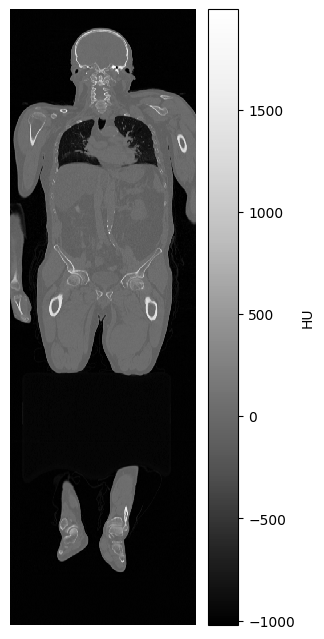

In [12]:
plt.figure(figsize=(3,8))
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

Notice that he's upside-down! We can manually reverse the axis, or we can use MONAI functionality to modify the CT. Firstly we add a channel dimension, since this is required for most AI applications

In [13]:
CT.shape

torch.Size([512, 512, 975])

In [14]:
channel_transform = EnsureChannelFirst()
CT = channel_transform(CT)
CT.shape

torch.Size([1, 512, 512, 975])

Now we can reorient the CT image:

In [15]:
orientation_transform = Orientation(axcodes=('LPS'))
CT = orientation_transform(CT)

Now obtain the coronal slice

In [16]:
CT_coronal_slice = CT[0,:,256].cpu().numpy()

Now plot again

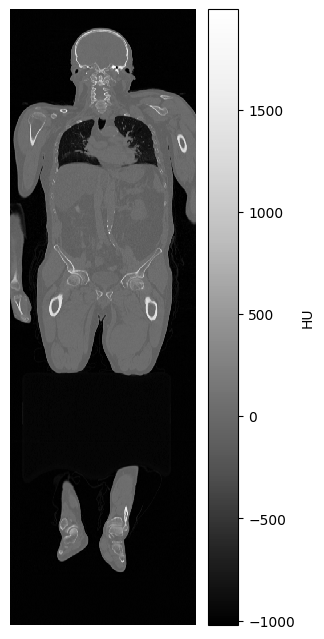

In [17]:
plt.figure(figsize=(3,8))
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

Alternatively, we can combine all these transforms in one go when we open the image data:

In [18]:
preprocessing_pipeline = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    Orientation(axcodes='LPS')
])

And we can open using this preprocessing pipeline:

In [19]:
CT = preprocessing_pipeline(CT_folder)
CT_coronal_slice = CT[0,:,256].cpu().numpy()

And plot:

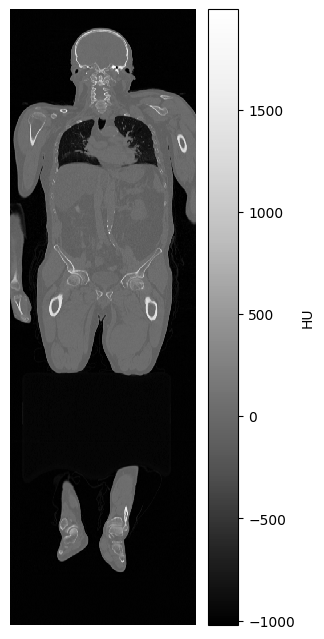

In [20]:
plt.figure(figsize=(3,8))
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

One other option (which is typically done) is to use the "dictionary" version of all the transforms above. This is done by adding a `d` to the end of the transforms, such as `LoadImaged`.
* These transforms take in a dictionary with keys-value pairs

In [21]:
data = {'image': CT_folder, 'some_other_key': 42}

In [22]:
preprocessing_pipeline = Compose([
    LoadImaged(keys='image', image_only=True),
    EnsureChannelFirstd(keys='image'),
    Orientationd(keys='image',axcodes='LPS')
])

In [23]:
data = preprocessing_pipeline(data)

In [24]:
data

{'image': metatensor([[[[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           ...,
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]],
 
          [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           ...,
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]],
 
          [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           

# Part 2: Segmentation Model

First we'll download the segmentation model

* Obtained from https://monai.io/model-zoo.html

In [25]:
model_name = "wholeBody_ct_segmentation"
download(name=model_name, bundle_dir=datadir)

2024-04-25 20:46:06,115 - INFO - --- input summary of monai.bundle.scripts.download ---
2024-04-25 20:46:06,115 - INFO - > name: 'wholeBody_ct_segmentation'
2024-04-25 20:46:06,115 - INFO - > bundle_dir: 'C:\\Users\\OskarK\\Desktop\\Segmentation\\Data'
2024-04-25 20:46:06,115 - INFO - > source: 'monaihosting'
2024-04-25 20:46:06,130 - INFO - > remove_prefix: 'monai_'
2024-04-25 20:46:06,131 - INFO - > progress: True
2024-04-25 20:46:06,131 - INFO - ---




wholeBody_ct_segmentation_v0.2.3.zip: 133MB [00:14, 9.72MB/s]                              

2024-04-25 20:46:21,115 - INFO - Downloaded: C:\Users\OskarK\Desktop\Segmentation\Data\wholeBody_ct_segmentation_v0.2.3.zip
2024-04-25 20:46:21,115 - INFO - Expected md5 is None, skip md5 check for file C:\Users\OskarK\Desktop\Segmentation\Data\wholeBody_ct_segmentation_v0.2.3.zip.
2024-04-25 20:46:21,115 - INFO - Writing into directory: C:\Users\OskarK\Desktop\Segmentation\Data.


We first set the paths of where we downloaded the model parameters (`model.pt`) and a file called `inference.json`.

In [30]:
model_path = os.path.join(datadir, 'wholeBody_ct_segmentation', 'models', 'model_lowres.pt')
config_path = os.path.join(datadir, 'wholeBody_ct_segmentation', 'configs', 'inference.json')

From this we create a `config` instance which lets us read from the `json` file

In [31]:
config = ConfigParser()
config.read_config(config_path)

## Preprocessing Pipeline

From this we can extract the preprocessing pipeline specified by the `inference.json` file
* These are all the operations applied to the data before feeding it to the model

In [32]:
preprocessing = config.get_parsed_content("preprocessing")

Note that this preprocessing pipeline uses `LoadImaged` instead of `LoadImage`. The `d` at the end refers to the fact that everything should be fed in as a dictionary. The `keys` argument are the keys of the dictionary by which to apply the transform to

In [33]:
data = preprocessing({'image': CT_folder})

In this case, the operations have only been applied to things with the key `'image'`. We could add extra keys and nothing would happen.

## Model

Now we can obtain the model using the `'network'` key from the json file

In [34]:
model = config.get_parsed_content("network")

Note at the moment that the model is initialized with random parameters. We need to configure it with the parameters given by the `model.pt` file. Since we won't be training it (only use it for evaluation), we'll use the `eval()` function

In [36]:
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval();

## Inferer

The `"inferer"` pipeline takes in the data and the model, and returns model output. It contains some extra processing steps (in this case it breaks the data into 96x96x96 chunks before feeding it into the model)

In [37]:
inferer = config.get_parsed_content("inferer")

## Postprocessing

Finally, once the model has finished running, there will be postprocessing that needs to be done on the data

* **IMPORTANT**: The postprocessing automaticcally saves the data to disk. I have manually deleted the `"SaveImaged"` from the postprocessing pipeline in the json file

In [38]:
postprocessing = config.get_parsed_content("postprocessing")

In [39]:
data['image'].unsqueeze(0).shape

torch.Size([1, 1, 167, 167, 650])

# Prediction Time :)

We can now combine all these pipelines to obtain organ masks for our data

In [40]:
data = preprocessing({'image': CT_folder}) # returns a dictionary
# 2. Compute mask prediction, add it to dictionary
with torch.no_grad():
    # Have to add additional batch dimension to feed into model
    data['pred'] = inferer(data['image'].unsqueeze(0), network=model)
# Remove batch dimension in image and prediction
data['pred'] = data['pred'][0]
data['image'] = data['image'][0]
# Apply postprocessing to data
data = postprocessing(data)
segmentation = torch.flip(data['pred'][0], dims=[2])
segmentation = segmentation.cpu().numpy()

2024-04-25 20:52:46,789 INFO image_writer.py:197 - writing: C:\Users\OskarK\Desktop\Segmentation\Data\Mask\1.3.6.1.4.1.14519.5.2.1.3320.3273\1.3.6.1.4.1.14519.5.2.1.3320.3273_trans.nii.gz


In [41]:
slice_idx = 250
CT_coronal_slice = CT[0,:,slice_idx].cpu().numpy()
segmentation_coronal_slice = segmentation[:,slice_idx]

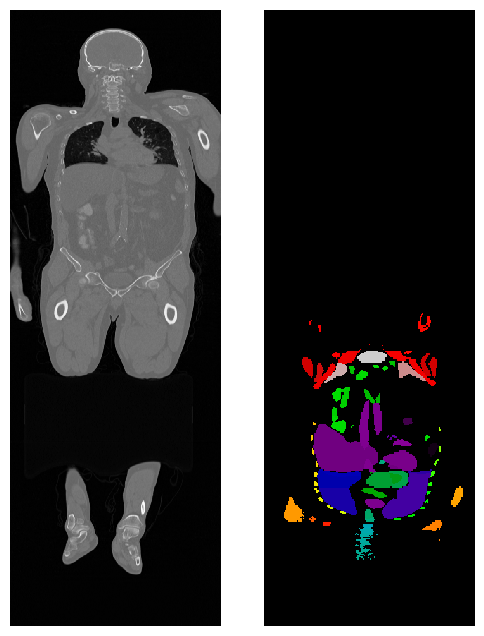

In [42]:
plt.subplots(1,2,figsize=(6,8))
plt.subplot(121)
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.axis('off')
plt.subplot(122)
plt.pcolormesh(segmentation_coronal_slice.T, cmap='nipy_spectral')
plt.axis('off')
plt.show()

The mask can be used for many purposes
* Radiotherapy planning to avoid certain organs
* (My research) utilization in SPECT/PET reconstruction algorithms to improve quantitation
* Compute organ volumes

**Example**: Computing bladder volume

In [43]:
number_bladder_voxels = (segmentation==7).sum().item()
voxel_volume_cm3 = np.prod(CT.meta['spacing']/10)
bladder_volume = number_bladder_voxels * voxel_volume_cm3
print(f'Bladder Volume {bladder_volume:.1f}cm^3')

Bladder Volume 335.6cm^3
